In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# **Predicting NBA playoff teams**
The NBA (National Basketball Association) playoffs are one of the most exciting times of the year for basketball fans. Each season, teams compete fiercely for a spot in the playoffs, aiming to secure a chance at the ultimate prize: the NBA championship. I will try to predict which team secured a spot in the playoffs in a given year, however, this can be a challenging task.

I will use the following dataset:https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats (using the files "Team Stats Per Game" and "Team Summaries"), which contains stats and advanced stats of NBA teams in the regular season from 1983 to 2024.

I will train the model on the dataset of NBA teams regular season stats up untill 2022, and then test it in the year 2023.


## Cleaning NBA Teams Data

### Loading the dataset


In [ ]:
per_game = pd.read_csv('/content/drive/MyDrive/NBA Stats (1947-present)/Team Stats Per Game.csv')
summaries = pd.read_csv('/content/drive/MyDrive/NBA Stats (1947-present)/Team Summaries.csv')

First of all, let's select all the season after 1984, since the conferences and the playoff spots before this year were structured in a different way, so it wouldn't make sense to train a model on that data.
Let's also avoid taking the 2024 season, since it is not over yet, and could lead to some misleading data

In [ ]:
per_game = per_game[(per_game['season'] >= 1984) & (per_game['season'] != 2024)]
summaries = summaries[(summaries['season'] >= 1984) & (summaries['season'] != 2024)]

Now let's see the data we have and discard all useless features (like abbreviation), all features that would be too explicit (wins and losses) and all features that are not necessary (like the fg stats, since we already have percentages for 2 point and 3 point shots)

In [ ]:
per_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 31 to 1203
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         1173 non-null   int64  
 1   lg             1173 non-null   object 
 2   team           1173 non-null   object 
 3   abbreviation   1133 non-null   object 
 4   playoffs       1173 non-null   bool   
 5   g              1173 non-null   float64
 6   mp_per_game    1173 non-null   float64
 7   fg_per_game    1173 non-null   float64
 8   fga_per_game   1173 non-null   float64
 9   fg_percent     1173 non-null   float64
 10  x3p_per_game   1173 non-null   float64
 11  x3pa_per_game  1173 non-null   float64
 12  x3p_percent    1173 non-null   float64
 13  x2p_per_game   1173 non-null   float64
 14  x2pa_per_game  1173 non-null   float64
 15  x2p_percent    1173 non-null   float64
 16  ft_per_game    1173 non-null   float64
 17  fta_per_game   1173 non-null   float64
 18  ft_perc

In [ ]:
columns_to_drop = ['lg', 'g', 'mp_per_game', 'abbreviation', 'fg_per_game', 'fga_per_game', 'fg_percent', 'trb_per_game']
per_game.drop(columns=columns_to_drop, inplace=True)

In [ ]:
summaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 31 to 1203
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            1173 non-null   int64  
 1   lg                1173 non-null   object 
 2   team              1173 non-null   object 
 3   abbreviation      1133 non-null   object 
 4   playoffs          1173 non-null   bool   
 5   age               1173 non-null   float64
 6   w                 1133 non-null   float64
 7   l                 1133 non-null   float64
 8   pw                1173 non-null   float64
 9   pl                1173 non-null   float64
 10  mov               1173 non-null   float64
 11  sos               1173 non-null   float64
 12  srs               1173 non-null   float64
 13  o_rtg             1173 non-null   float64
 14  d_rtg             1173 non-null   float64
 15  n_rtg             1133 non-null   float64
 16  pace              1173 non-null   float64

In [ ]:
columns_to_drop = ['season', 'lg', 'team', 'abbreviation', 'playoffs', 'w', 'l','arena', 'attend', 'attend_g']
summaries.drop(columns=columns_to_drop, inplace=True)

### Adding noise

Now let's concatenate the datasets and take a look at our data

In [ ]:
teams_df = pd.concat([per_game, summaries], axis=1)
teams_df.reset_index(drop=True, inplace=True)

teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            1173 non-null   int64  
 1   team              1173 non-null   object 
 2   playoffs          1173 non-null   bool   
 3   x3p_per_game      1173 non-null   float64
 4   x3pa_per_game     1173 non-null   float64
 5   x3p_percent       1173 non-null   float64
 6   x2p_per_game      1173 non-null   float64
 7   x2pa_per_game     1173 non-null   float64
 8   x2p_percent       1173 non-null   float64
 9   ft_per_game       1173 non-null   float64
 10  fta_per_game      1173 non-null   float64
 11  ft_percent        1173 non-null   float64
 12  orb_per_game      1173 non-null   float64
 13  drb_per_game      1173 non-null   float64
 14  ast_per_game      1173 non-null   float64
 15  stl_per_game      1173 non-null   float64
 16  blk_per_game      1173 non-null   float64


As we can see, the starting dataset is clean, so we have to add some noise in it in order to simulate a real-world dataset. We will select 10 random columns in order to do this

In [ ]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [ ]:
noisy_cols = ['x3p_per_game', 'ft_per_game', 'orb_per_game', 'blk_per_game', 'pf_per_game', 'sos', 'pace', 'f_tr', 'x3p_ar', 'opp_ft_fga']

In [ ]:
amount_of_noise = 0.08 # percentage of noise

for col in noisy_cols:
    if col in teams_df.columns:
        teams_df[col] = add_missing(teams_df[col], amount_of_noise)
    else:
        print(f"Column {col} does not exist in the DataFrame.")

In [ ]:
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            1173 non-null   int64  
 1   team              1173 non-null   object 
 2   playoffs          1173 non-null   bool   
 3   x3p_per_game      1080 non-null   float64
 4   x3pa_per_game     1173 non-null   float64
 5   x3p_percent       1173 non-null   float64
 6   x2p_per_game      1173 non-null   float64
 7   x2pa_per_game     1173 non-null   float64
 8   x2p_percent       1173 non-null   float64
 9   ft_per_game       1080 non-null   float64
 10  fta_per_game      1173 non-null   float64
 11  ft_percent        1173 non-null   float64
 12  orb_per_game      1080 non-null   float64
 13  drb_per_game      1173 non-null   float64
 14  ast_per_game      1173 non-null   float64
 15  stl_per_game      1173 non-null   float64
 16  blk_per_game      1080 non-null   float64


### Dividing in previus seasons and current season

In [ ]:
prev_ssn = teams_df[teams_df['season'] != 2023]
current_ssn = teams_df[teams_df['season'] == 2023]

prev_ssn = prev_ssn.reset_index(drop=True)
current_ssn = current_ssn.reset_index(drop=True)

Let's try to understand what are the features with the most and less correlation with our target column, playoffs

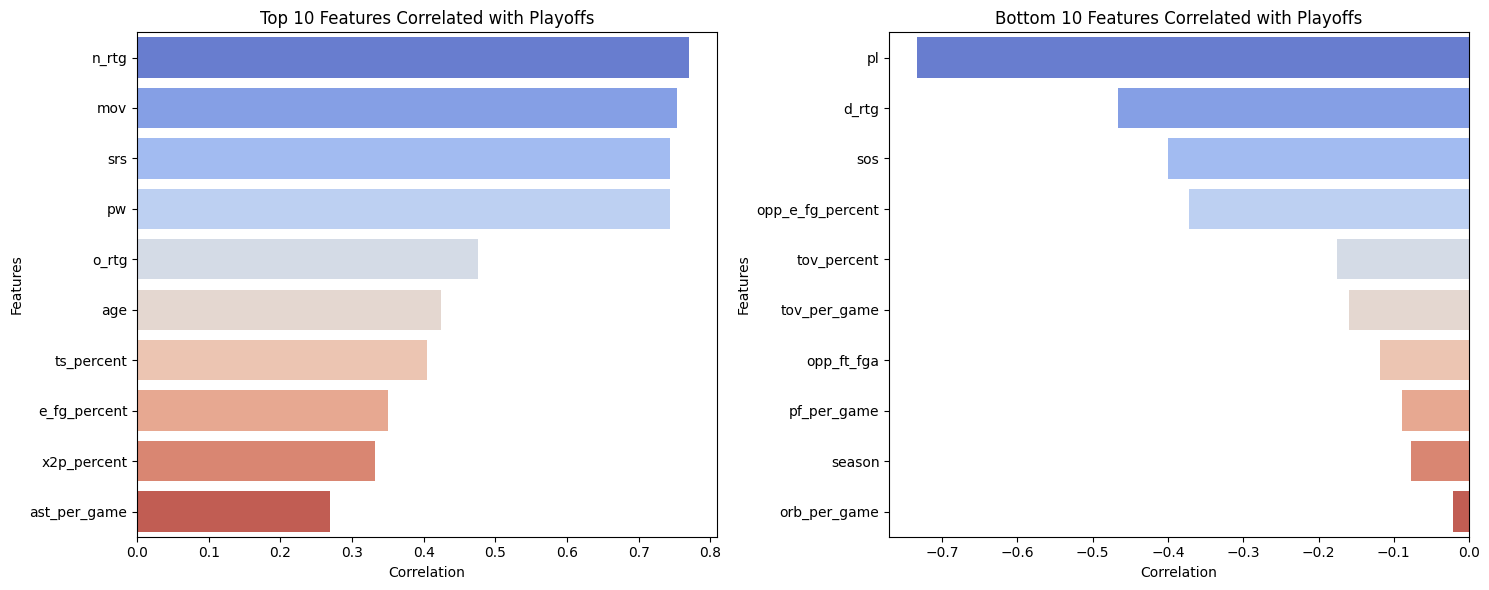

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = prev_ssn.corr()

# Sort correlations with 'playoffs' column in descending order
corr_with_playoffs = corr_matrix['playoffs'].drop('playoffs').sort_values(ascending=False)

# Get top 10 and bottom 10 correlated features
top_10_corr = corr_with_playoffs.head(10)
bottom_10_corr = corr_with_playoffs.tail(10)[::-1]  # Reverse the order to start from positive values

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting top 10 correlated features
sns.barplot(ax=axes[0], x=top_10_corr.values, y=top_10_corr.index, palette="coolwarm")
axes[0].set_title('Top 10 Features Correlated with Playoffs')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Features')

# Plotting bottom 10 correlated features
sns.barplot(ax=axes[1], x=bottom_10_corr.values, y=bottom_10_corr.index, palette="coolwarm")
axes[1].set_title('Bottom 10 Features Correlated with Playoffs')
axes[1].set_xlabel('Correlation')
axes[1].set_ylabel('Features')

# Adjust layout
plt.tight_layout()
plt.show()


As we can see, the net rating is the most accurate stat in order to determine the place in the playoffs of a team, followed by the margin of victory, simple rating system and pythagorean wins.
As for the bottom ten features, for which the less the better in order to have a good seed at the end of a season: the top three are pythagorean losses, defensive rating and strength of schedule.

### Data Transformation Pipeline

Let's define the Feature Matrix, indicating the features we will use for the evaluation

In [ ]:
X = prev_ssn[['x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game','x2pa_per_game',
              'x2p_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game',
              'drb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game',
              'pf_per_game', 'pts_per_game', 'age', 'pw', 'pl', 'mov', 'sos', 'srs', 'o_rtg',
              'd_rtg', 'n_rtg', 'pace', 'f_tr', 'x3p_ar', 'ts_percent', 'e_fg_percent', 'tov_percent',
              'orb_percent', 'ft_fga', 'opp_e_fg_percent', 'opp_tov_percent', 'opp_drb_percent', 'opp_ft_fga']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   x3p_per_game      1049 non-null   float64
 1   x3pa_per_game     1142 non-null   float64
 2   x3p_percent       1142 non-null   float64
 3   x2p_per_game      1142 non-null   float64
 4   x2pa_per_game     1142 non-null   float64
 5   x2p_percent       1142 non-null   float64
 6   ft_per_game       1050 non-null   float64
 7   fta_per_game      1142 non-null   float64
 8   ft_percent        1142 non-null   float64
 9   orb_per_game      1050 non-null   float64
 10  drb_per_game      1142 non-null   float64
 11  ast_per_game      1142 non-null   float64
 12  stl_per_game      1142 non-null   float64
 13  blk_per_game      1053 non-null   float64
 14  tov_per_game      1142 non-null   float64
 15  pf_per_game       1049 non-null   float64
 16  pts_per_game      1142 non-null   float64


Now that we have the Feature Matrix, let's transform the data correclty, and then we will define our pipeline

All of our data is of the same type: we do not have any categorical features.
Some features contain noise and other don't, so we will treat them differently

In [ ]:
noisy_f = ['x3p_per_game', 'ft_per_game', 'orb_per_game', 'blk_per_game',
           'pf_per_game', 'sos', 'pace', 'f_tr', 'x3p_ar', 'opp_ft_fga']

clean_f = ['x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game',
           'x2p_percent', 'fta_per_game', 'ft_percent', 'drb_per_game',
           'ast_per_game','stl_per_game', 'tov_per_game', 'pts_per_game',
           'age', 'pw', 'pl', 'mov', 'srs', 'o_rtg', 'd_rtg', 'n_rtg',
           'ts_percent', 'e_fg_percent', 'tov_percent', 'orb_percent',
           'ft_fga', 'opp_e_fg_percent', 'opp_tov_percent', 'opp_drb_percent']

In [ ]:
noisy_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Safety procedure: for clean data, if there are still missing values we just substitute zero
clean_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('noisy', noisy_preprocessor, noisy_f),
        ('clean', clean_preprocessor, clean_f)
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('noisy',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['x3p_per_game', 'ft_per_game', 'orb_per_game',
                                  'blk_per_game', 'pf_per_game', 'sos', 'pace',
                                  'f_tr', 'x3p_ar', 'opp_ft_fga']),
                                ('clean',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['x3pa_per_game', 'x3p_percent',
                                  'x2p_per_game', 'x2pa_per_game',
                                  'x2p_percent', 'fta_per_game', 'ft_percent',
                                  'drb_per_game', 'ast_per_game',
                                  'stl_per_game', 'tov_per_game',
                                  'pts_per_game', 'age', 'pw', 'pl', 'mov',
                                  'srs', 'o_rtg', 'd_rtg', 'n_rtg',
                                  'ts_percent', 'e_fg_percent', 'tov_percent',
                                  'orb_percent', 'ft_fga', 'opp_e_fg_percent',
                                  'opp_tov_percent', 'opp_drb_percent'])])

Let us now define our target variable

In [ ]:
y = prev_ssn['playoffs']

And then get the train and test over all of our training data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [ ]:
pip = IMBPipeline([
    ('prep', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [ ]:
pip.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('noisy',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x3p_per_game',
                                                   'ft_per_game',
                                                   'orb_per_game',
                                                   'blk_per_game',
                                                   'pf_per_game', 'sos', 'pace',
                                                   'f_tr', 'x3p_ar',
                                                   'opp_ft_fga']),
                                                 ('clean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler...
                                                   'fta_per_game', 'ft_percent',
                                                   'drb_per_game',
                                                   'ast_per_game',
                                                   'stl_per_game',
                                                   'tov_per_game',
                                                   'pts_per_game', 'age', 'pw',
                                                   'pl', 'mov', 'srs', 'o_rtg',
                                                   'd_rtg', 'n_rtg',
                                                   'ts_percent', 'e_fg_percent',
                                                   'tov_percent', 'orb_percent',
                                                   'ft_fga', 'opp_e_fg_percent',
                                                   'opp_tov_percent',
                                                   'opp_drb_percent'])])),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

## Model Selection with Nested Cross-Validation

### Initial model selection

Let's start by checking different models and analizing their performance.

The following are the models and configurations we will use:
- For Sampling, we'll try to use SMOTE (Synthetic Minority Over-sampling Technique) and a RandomOverSampler.
- For Dimensionality Reduction we will try to use PCA, LDA and SequentialFeatureSelector that uses Perceptron or LogisticRegression as estimators.
- For classifiers, we'll try different configurations of Perceptron, LogisticRegression, KNeighbors, RandomForest, SVC, XGBoost and GradientBoostingClassifier.

In [ ]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(1e-2, 1e1),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1,3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10, 25, 50, 100, 125]
    },
    {
        'classifier': [SVC()],
        'classifier__C': loguniform(1e-2, 1e1),
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': loguniform(1e-4, 1),
        'classifier__class_weight': [None, 'balanced'],
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [100, 150, 200, 250, 300],
        'classifier__learning_rate': loguniform(0.01, 0.03),
        'classifier__max_depth': [3, 6, 9],
        'classifier__subsample': [0.7, 0.8, 1.0]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200, 250, 300],
        'classifier__learning_rate': loguniform(0.01, 0.03),
        'classifier__max_depth': [3, 6, 9],
        'classifier__subsample': [0.7, 0.8, 1.0],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2', None],
        'classifier__loss': ['deviance', 'exponential']
    }
]

In [ ]:
all_configs = [] # list of dictionaries where each dictionary is an Hyperparameter of the pipeline
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [ ]:
len(all_configs)

84

In [ ]:
# Inner loop
rs = RandomizedSearchCV(
    pip,
    param_distributions=all_configs,
    n_iter=len(all_configs)*10,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42
)

# Outer loop
scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END ......................................., score=0.893 total time=24.1min
Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END ......................................., score=0.918 total time=24.2min
Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END ......................................., score=0.883 total time=24.1min
Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END ......................................., score=0.945 total time=25.9min
Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV] END ......................................., score=0.902 total time=25.3min


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.9)
None
GradientBoostingClassifier(learning_rate=0.012463805191569864, loss='deviance',
                           max_features='auto') {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.012463805191569864, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.8934010152284264
----------
RandomOverSampler(sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
RandomForestClassifier(n_estimators=50) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_l

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9365558912386707, F1 on test set:0.9105691056910571
F1 on training set:1.0, F1 on test set:0.9354838709677419
F1 on training set:1.0, F1 on test set:0.9268292682926831
F1 on training set:0.9850448654037885, F1 on test set:0.931726907630522
F1 on training set:0.9366834170854271, F1 on test set:0.9236947791164659


The best models are without any doubt RandomForestClassifier and GradientBoostingClassifier.
We have some performances with little to none overfitting and some that are subject to overfitting.

### Final model selection

In this next step we will focus on the two best models again, but we are going to add more parameters, in order to define which one , between the two, is the best, since their performances were very similar.

In [ ]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

classifier_configs = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 10, 15, 20],
        'classifier__min_samples_split': [2, 4, 6, 10],
        'classifier__min_samples_leaf': [1, 2, 4, 6]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200, 250, 300, 350, 400],
        'classifier__learning_rate': loguniform(0.01, 0.05),
        'classifier__max_depth': [3, 4, 5, 6, 7],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__min_samples_split': [2, 5, 10, 15],
        'classifier__min_samples_leaf': [1, 2, 4, 6]
    }
]

In [ ]:
all_configs2 = [] # list of dictionaries where each dictionary is an Hyperparameter of the pipeline
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs2.append(dict(all_parameters))

In [ ]:
len(all_configs2)

24

In [ ]:
# Inner loop
rs2 = RandomizedSearchCV(
    pip,
    param_distributions=all_configs2,
    n_iter=len(all_configs2)*10,
    cv=5,
    scoring='f1',
    verbose=1,
    random_state=42
)

# Outer loop
scores2 = cross_validate(
    rs2,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.870 total time=13.0min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.903 total time=12.9min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.879 total time=12.8min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.945 total time=12.9min
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ......................................., score=0.911 total time=12.5min


In [ ]:
for index, estimator in enumerate(scores2['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores2['test_score'][index])
    print('-'*10)

None
None
GradientBoostingClassifier(learning_rate=0.024538336290995777,
                           min_samples_leaf=6, min_samples_split=10,
                           n_estimators=150, subsample=0.6) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.024538336290995777, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.6, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.87
----------
SMOTE(n_jobs=-1, sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(10, 10), scoring='f1')
RandomForestClassifier(min_samples_leaf=2, min_samples_split=6,
                       n_estimators=200) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weigh

In [ ]:
for estimator in scores2['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9469469469469469, F1 on test set:0.9322709163346613
F1 on training set:0.9701195219123506, F1 on test set:0.9274193548387097
F1 on training set:0.96318407960199, F1 on test set:0.9274193548387097
F1 on training set:0.9979919678714859, F1 on test set:0.936
F1 on training set:0.9470529470529472, F1 on test set:0.9173553719008264


The top two performing models belong to GradientBoostingClassifier, so i will go on with this model.

## Hyperparameter Optimization


Now that we have our best model, we can run once again a nested cross validation loop in order have the best ranges of hyperparameters and the best combination of sampling and dimensionality reduction tools.

In [ ]:
best_pip = IMBPipeline([
    ('prep', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', GradientBoostingClassifier())
])

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

classifier_configs = [
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200, 250, 300, 350, 400],
        'classifier__learning_rate': [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05],
        'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8],
        'classifier__subsample': [0.4, 0.5, 0.6, 0.7, 0.8],
        'classifier__min_samples_split': [5, 7, 10, 12, 15],
        'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]
    }
]

In [ ]:
all_configs3 = [] # list of dictionaries where each dictionary is an Hyperparameter of the pipeline
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs3.append(dict(all_parameters))

In [ ]:
len(all_configs3)

12

In [ ]:
# Inner loop
rs3 = RandomizedSearchCV(
    best_pip,
    param_distributions=all_configs3,
    n_iter=len(all_configs3)*10,
    cv=5,
    scoring='f1'
)

# Outer loop
scores3 = cross_validate(
    rs3,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

[CV] END ......................................., score=0.899 total time= 9.0min
[CV] END ......................................., score=0.917 total time= 9.0min
[CV] END ......................................., score=0.897 total time= 9.6min
[CV] END ......................................., score=0.945 total time=10.6min
[CV] END ......................................., score=0.906 total time= 6.9min


In [ ]:
for index, estimator in enumerate(scores3['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores3['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.9)
None
GradientBoostingClassifier(learning_rate=0.03, max_depth=4, min_samples_leaf=4,
                           min_samples_split=15, n_estimators=150,
                           subsample=0.8) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.03, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.8989898989898989
----------
SMOTE(n_jobs=-1, sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
GradientBoostingClassifier(learning_rate=0.02, max_depth=2, min_samples_leaf=3,
                           min_samples_split=7,

In [ ]:
for estimator in scores3['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9740518962075847, F1 on test set:0.9322709163346613
F1 on training set:0.9280648429584599, F1 on test set:0.9142857142857143
F1 on training set:0.9519038076152304, F1 on test set:0.9180327868852459
F1 on training set:1.0, F1 on test set:0.937007874015748
F1 on training set:1.0, F1 on test set:0.928


As we can see the first and last models are the best:
- The best sampler is either None or SMOTE, with strategy of either 'minority' or '0.9'
- The best dimensionality reduction is either 'None' or SequentialFeatureSelector, and we will try it only with LogisticRegression.

As for the Hyperparameters of GradientBoostingClassifier, we will try all possible values that appeared in the previus models and also explore in more detail the ranges

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 0.9]
    },
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [SFS(estimator=LogisticRegression(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [LogisticRegression()],
        'dim_reduction__k_features' : [5,7]
    }
]

classifier_configs = [
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450],
        'classifier__learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03],
        'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8],
        'classifier__subsample': [0.4, 0.5, 0.6, 0.7, 0.8],
        'classifier__min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8]
    }
]

In [ ]:
all_configs4 = [] # list of dictionaries where each dictionary is an Hyperparameter of the pipeline
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs4.append(dict(all_parameters))

In [ ]:
len(all_configs4)

4

In [ ]:
# Inner loop
rs4 = RandomizedSearchCV(
    best_pip,
    param_distributions=all_configs4,
    n_iter=len(all_configs4)*10,
    cv=5,
    scoring='f1'
)

# Outer loop
scores4 = cross_validate(
    rs4,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

[CV] END ......................................., score=0.879 total time= 7.6min
[CV] END ......................................., score=0.923 total time= 7.5min
[CV] END ......................................., score=0.901 total time= 6.9min
[CV] END ......................................., score=0.940 total time= 7.0min
[CV] END ......................................., score=0.912 total time= 7.1min


In [ ]:
for index, estimator in enumerate(scores4['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores4['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.9)
None
GradientBoostingClassifier(learning_rate=0.02, max_depth=2, min_samples_leaf=4,
                           min_samples_split=9, n_estimators=350,
                           subsample=0.7) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.02, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 350, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.7, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.8787878787878789
----------
SMOTE(n_jobs=-1, sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=7,
                           min_samples_split=14, 

In [ ]:
for estimator in scores4['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9437751004016065, F1 on test set:0.9285714285714286
F1 on training set:0.974974974974975, F1 on test set:0.9354838709677419
F1 on training set:1.0, F1 on test set:0.9206349206349207
F1 on training set:0.9839679358717435, F1 on test set:0.92
F1 on training set:0.9390609390609391, F1 on test set:0.9068825910931175


Since I am still not sure about the best model, i will run again randomized grid search, and then we will run GridSearch.

- SMOTE will have as only strategy '0.9'
- SFS will have 7 k features
- All GradientBoostingClassifier parameters have been optimized according to the highest performing models, but now the intervals left will be inspected even more in detail.

In [ ]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':[0.9]
    },
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [SFS(estimator=LogisticRegression(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [LogisticRegression()],
        'dim_reduction__k_features' : [7]
    }
]

classifier_configs = [
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480],
        'classifier__learning_rate': [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03],
        'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8],
        'classifier__subsample': [0.5, 0.55, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8],
        'classifier__min_samples_split': [8, 9, 10, 11, 12, 13, 14],
        'classifier__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9]
    }
]

In [ ]:
all_configs5 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs5.append(dict(all_parameters))

In [ ]:
len(all_configs5)

4

In [ ]:
# Inner loop
rs5 = RandomizedSearchCV(
    best_pip,
    param_distributions=all_configs5,
    n_iter=len(all_configs5)*10,
    cv=5,
    scoring='f1'
)

# Outer loop
scores5 = cross_validate(
    rs5,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

[CV] END ......................................., score=0.889 total time= 9.5min
[CV] END ......................................., score=0.906 total time= 9.0min
[CV] END ......................................., score=0.896 total time= 8.6min
[CV] END ......................................., score=0.940 total time= 9.1min
[CV] END ......................................., score=0.916 total time= 8.4min


In [ ]:
for index, estimator in enumerate(scores5['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores5['test_score'][index])
    print('-'*10)

None
None
GradientBoostingClassifier(learning_rate=0.0025, max_depth=6,
                           min_samples_leaf=7, min_samples_split=14,
                           n_estimators=410, subsample=0.6) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.0025, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 7, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 410, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.6, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.888888888888889
----------
None
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
GradientBoostingClassifier(learning_rate=0.001, max_depth=5, min_samples_leaf=7,
                           min_samples_split=11, n_estimators=340,
                           subsample=0.65) {'c

In [ ]:
for estimator in scores5['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9573835480673933, F1 on test set:0.9236947791164659
F1 on training set:0.9332042594385285, F1 on test set:0.9083969465648856
F1 on training set:0.9939879759519038, F1 on test set:0.9163346613545816
F1 on training set:0.9471585244267198, F1 on test set:0.9236947791164659
F1 on training set:0.96, F1 on test set:0.9354838709677419


I will go on analysing one last time the set up of the highest scoring model, so:
- We will keep the SMOTE sampler
- We will keep SFS as the only dimensionality reduction
- We will reduce further the ranges of the GradientBoostingClassifier

In [ ]:
sampler_configs = [
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':[0.9]
    },
]

dim_reduction_configs = [
    {
        'dim_reduction': [SFS(estimator=LogisticRegression(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [LogisticRegression()],
        'dim_reduction__k_features' : [7]
    }
]

classifier_configs = [
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440,445, 450, 455, 460],
        'classifier__learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01],
        'classifier__max_depth': [4, 5, 6],
        'classifier__subsample': [0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75],
        'classifier__min_samples_split': [10, 11, 12, 13, 14],
        'classifier__min_samples_leaf': [7, 8, 9]
    }
]

In [ ]:
all_configs6 = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs6.append(dict(all_parameters))

In [ ]:
rs6 = RandomizedSearchCV(
    best_pip,
    param_distributions=all_configs6,
    n_iter=len(all_configs6) * 30,
    n_jobs=-1,
    cv=5,
    scoring='f1'
    )

scores6 = cross_validate(
    rs6,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3
)

[CV] END ......................................., score=0.917 total time= 6.5min
[CV] END ......................................., score=0.904 total time= 6.0min
[CV] END ......................................., score=0.881 total time= 5.9min
[CV] END ......................................., score=0.935 total time= 6.0min
[CV] END ......................................., score=0.915 total time= 6.0min


In [ ]:
for index, estimator in enumerate(scores6['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores6['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')
GradientBoostingClassifier(learning_rate=0.001, max_depth=6, min_samples_leaf=8,
                           min_samples_split=10, n_estimators=395,
                           subsample=0.575) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.001, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 395, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.575, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.9170731707317075
----------
SMOTE(n_jobs=-1, sampling_strategy=0.9)
SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(7, 7), scoring='f1')


In [ ]:
for estimator in scores6['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9375619425173439, F1 on test set:0.9274193548387097
F1 on training set:0.9333333333333333, F1 on test set:0.9193548387096775
F1 on training set:0.948948948948949, F1 on test set:0.934959349593496
F1 on training set:0.9480000000000001, F1 on test set:0.9193548387096775
F1 on training set:0.9378757515030061, F1 on test set:0.9193548387096775


All of our models had similar performances: let's see their respective confusion matrixes, precision-recall curve and ROC curve in order to have more information about them

### Graphs

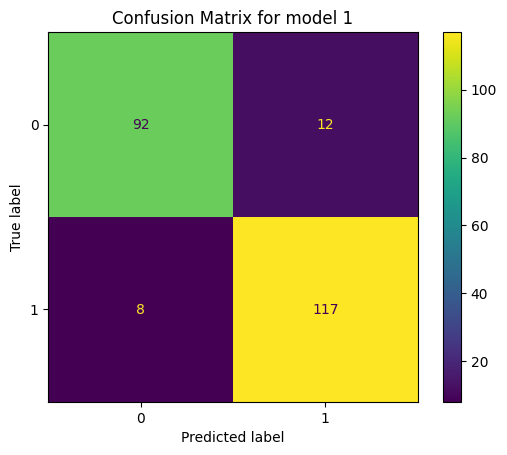

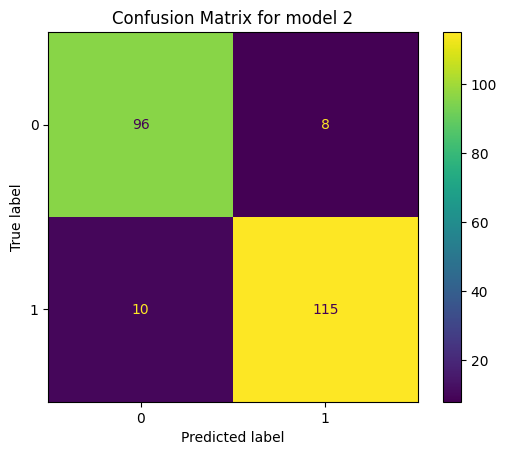

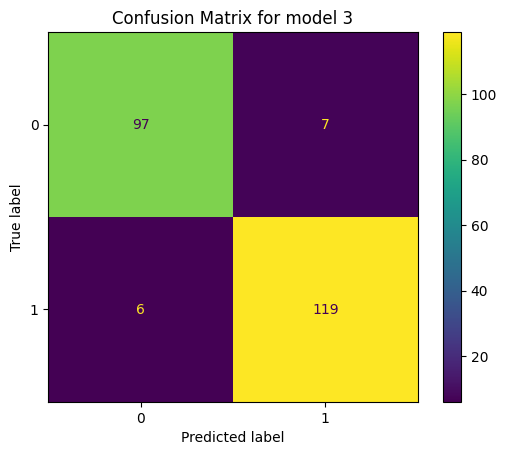

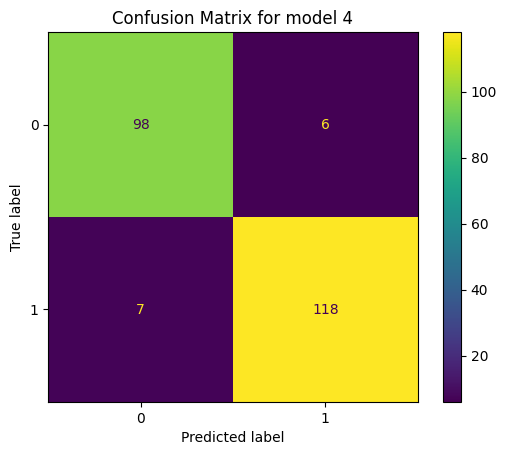

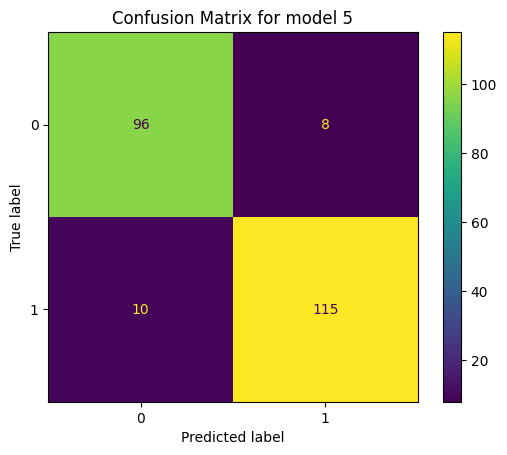

In [ ]:
for index, estimator in enumerate(scores6['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for model {index+1}')
    plt.show()

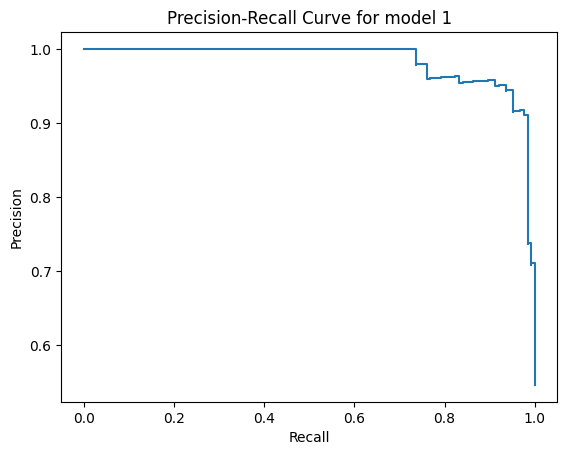

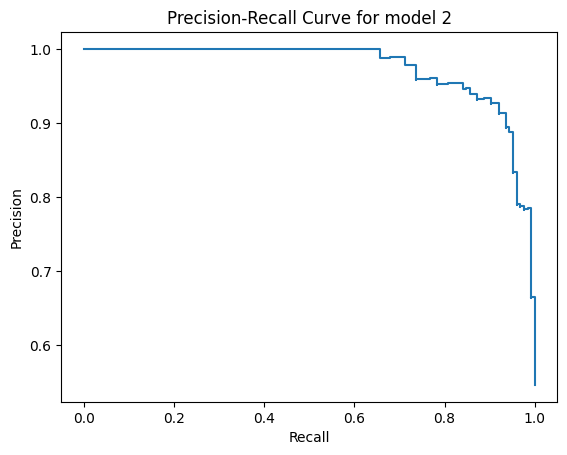

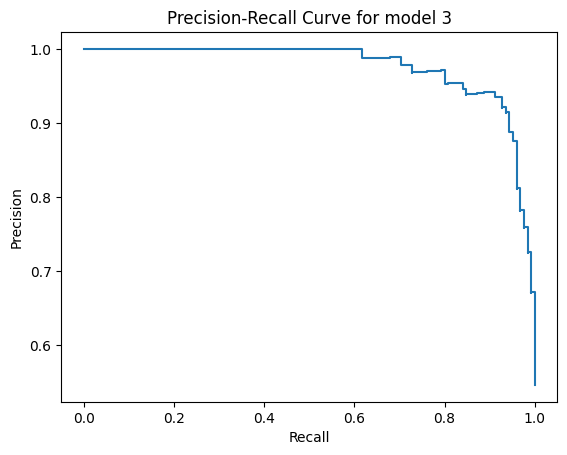

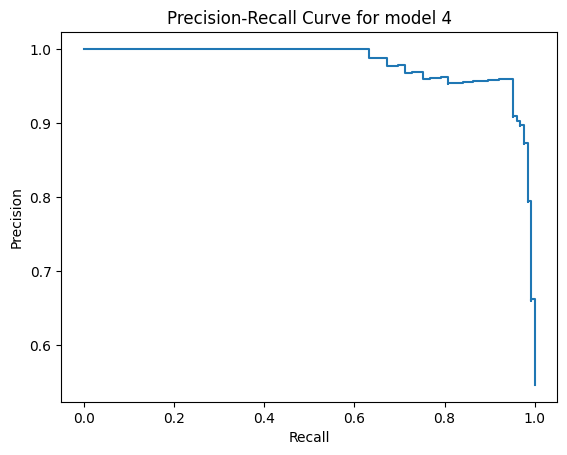

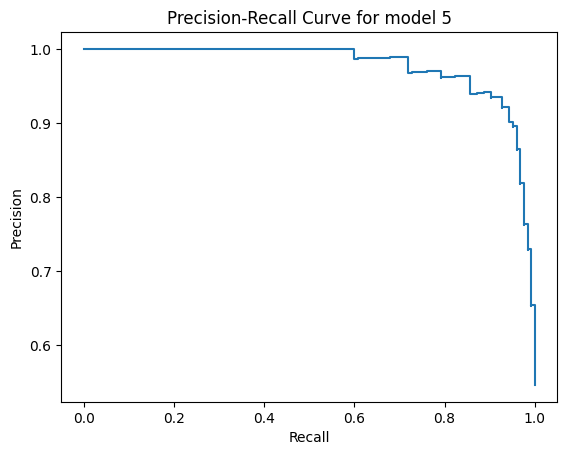

In [ ]:
for index, estimator in enumerate(scores6['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, pred_probs)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for model {index+1}')
    plt.show()

In [ ]:
average_precision_scores = []
for i, estimator in enumerate(scores6['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)
    pred_probs = best_model.predict_proba(X_test)[:, 1]
    average_precision = average_precision_score(y_test, pred_probs)
    average_precision_scores.append(average_precision)
    print(f'Model {i+1}: Average Precision = {average_precision}')


Model 1: Average Precision = 0.9845879162801361
Model 2: Average Precision = 0.9827079926429594
Model 3: Average Precision = 0.9803356796266943
Model 4: Average Precision = 0.981470378292495
Model 5: Average Precision = 0.9770958920406083


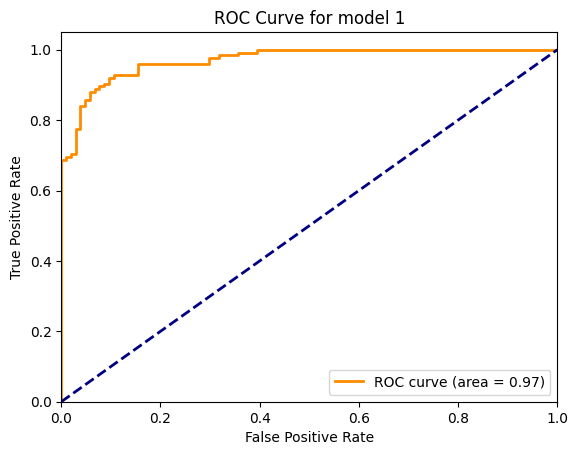

The AUC for model 1 is: 0.97


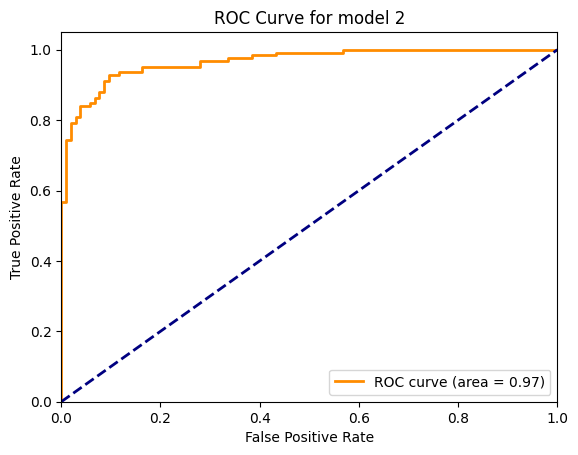

The AUC for model 2 is: 0.97


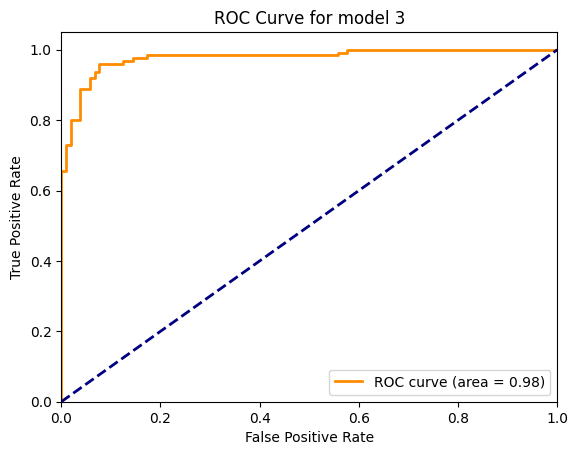

The AUC for model 3 is: 0.98


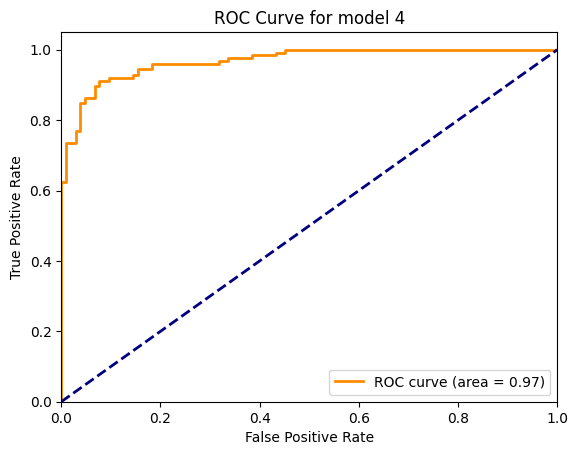

The AUC for model 4 is: 0.97


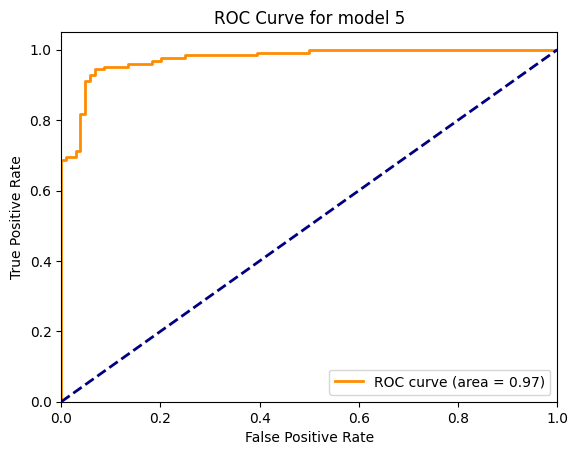

The AUC for model 5 is: 0.97


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

for index, estimator in enumerate(scores6['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for model {index+1}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'The AUC for model {index+1} is: {roc_auc:.2f}')

### Best model

I will choose the model 3, since it has the best F1 score, and also was one of the best by looking at the other metrics

In [ ]:
best_model = scores6['estimator'][3].best_estimator_

In [ ]:
best_model['classifier'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.005,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 420,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.675,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Learning and Validation Curve

Now we will take a look at the learning curve of the model with different training sizes, and then compute the validation curve for all the hyperparameters of our model, in order to optimize the perfromance and also minimize overfitting

### Learning Curve

Let's take a look at the learning curve, in order to see how many data is needed for the model to have a good performance

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

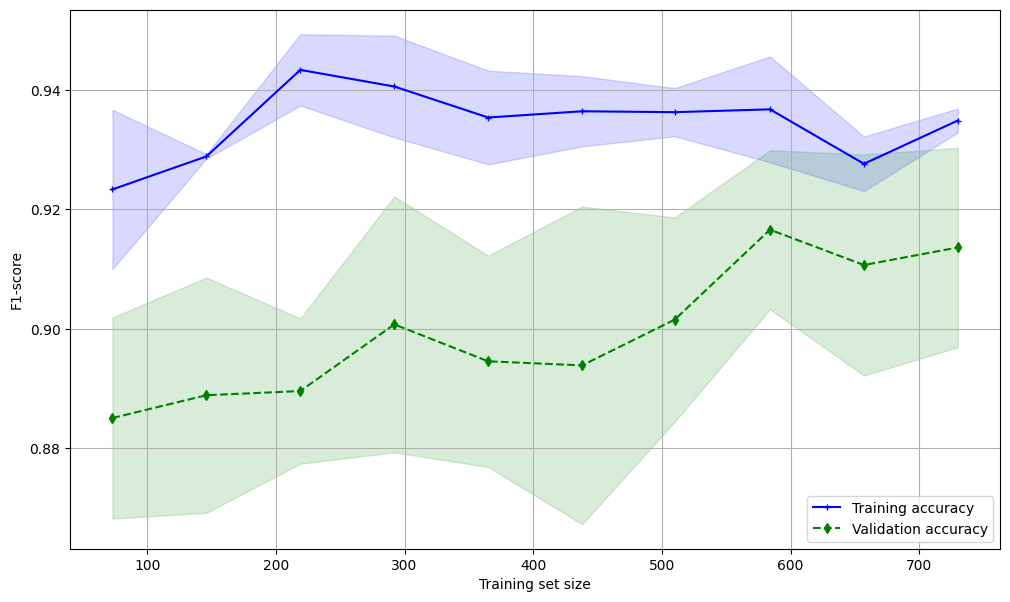

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
#ax.set_xlim([5, 735])

The more train size we have, the less overfitting

### Validation Curve for n_estimators

In [ ]:
range_estimators = [320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_estimators,
        param_name='classifier__n_estimators',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

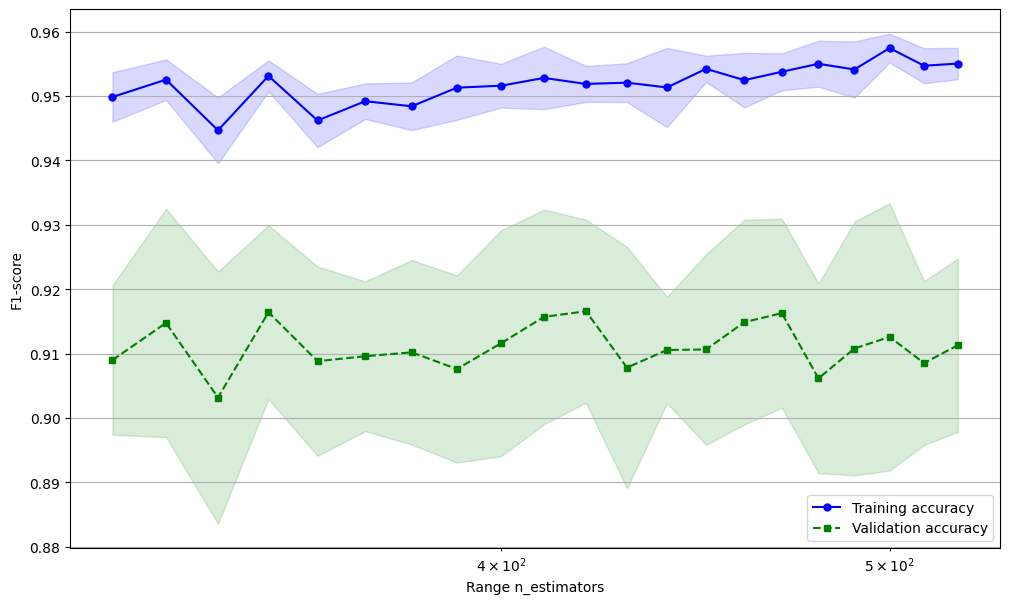

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_estimators, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_estimators,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_estimators, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_estimators,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Range n_estimators')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_xscale('log')

n_estimators was perfect the way it was in the model

### Validation Curve for learning_rate

In [ ]:
range_learning_rate = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.025, 0.05, 0.075, 0.1]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_learning_rate,
        param_name='classifier__learning_rate',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

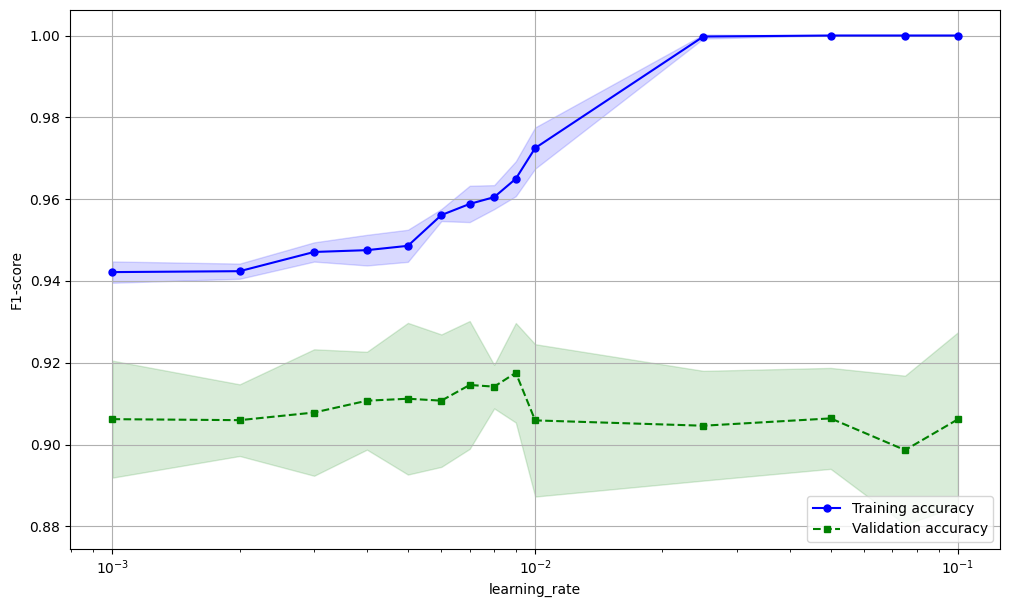

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_learning_rate, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_learning_rate,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_learning_rate, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_learning_rate,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('learning_rate')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
#ax.set_ylim([0.8, 1])
ax.set_xscale('log')
#ax.set_xlim([0.05,100])

The learning_rate seems to give it's best around 0.004, if we also take into account overfitting.

In [ ]:
best_model['classifier'].set_params(learning_rate=0.004)

GradientBoostingClassifier(learning_rate=0.004, max_depth=5, min_samples_leaf=8,
                           min_samples_split=14, n_estimators=420,
                           subsample=0.675)

### Validation Curve for max_depth

In [ ]:
range_depth = [2, 3, 4, 5, 6, 7, 8]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_depth,
        param_name='classifier__max_depth',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

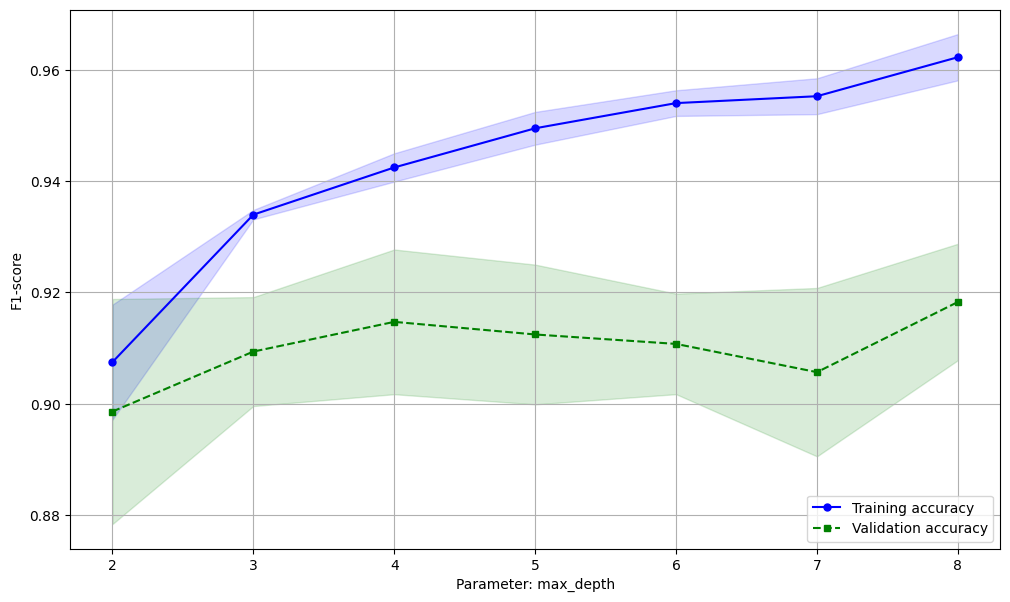

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_depth, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_depth,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_depth, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_depth,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: max_depth')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')

We will fix max_depth=4 in order to deal with overfitting

In [ ]:
best_model['classifier'].set_params(max_depth=4)

GradientBoostingClassifier(learning_rate=0.004, max_depth=4, min_samples_leaf=8,
                           min_samples_split=14, n_estimators=420,
                           subsample=0.77)

### Valudation Curve for subsample

In [ ]:
range_subsample = [0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.675, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_subsample,
        param_name='classifier__subsample',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

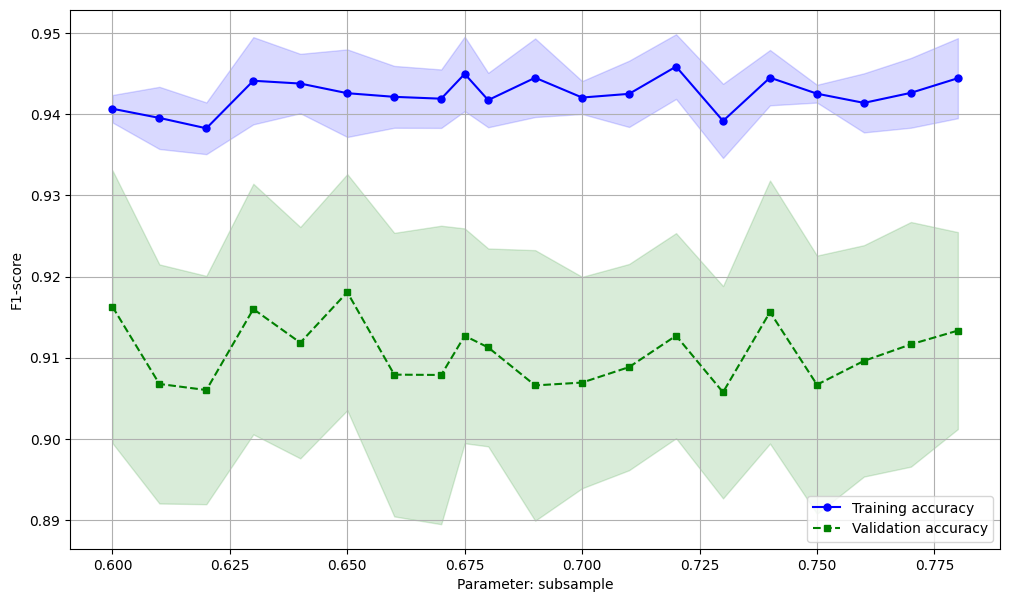

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_subsample, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_subsample,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_subsample, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_subsample,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: subsample')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')

We will fix the subsample to 0.65

In [ ]:
best_model['classifier'].set_params(subsample=0.65)

GradientBoostingClassifier(learning_rate=0.004, max_depth=4, min_samples_leaf=8,
                           min_samples_split=14, n_estimators=420,
                           subsample=0.65)

### Validation Curve for min_samples_split

In [ ]:
range_min_samples_split = [10, 11, 12, 13, 14, 15, 16, 17, 18]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_min_samples_split,
        param_name='classifier__min_samples_split',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

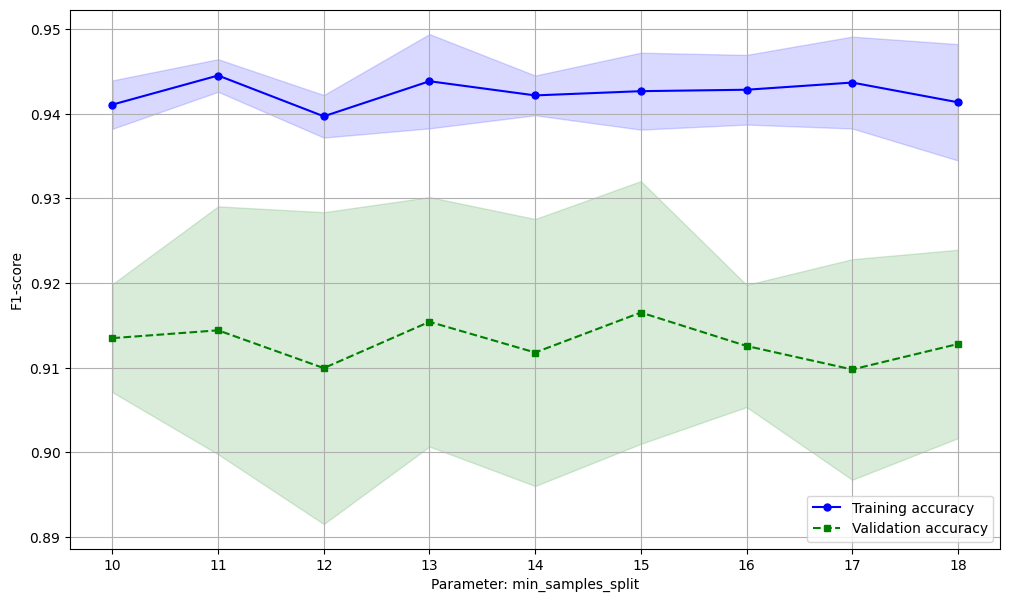

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_min_samples_split, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_min_samples_split,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_min_samples_split, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_min_samples_split,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: min_samples_split')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')

We will have min_samples_split at 15

In [ ]:
best_model['classifier'].set_params(min_samples_split=15)

GradientBoostingClassifier(learning_rate=0.004, max_depth=4,
                           min_samples_leaf=15, min_samples_split=15,
                           n_estimators=420, subsample=0.65)

### Validation Curve for min_sample_leaf

In [ ]:
range_min_samples_leaf = [5, 6, 7, 8, 9, 10, 11]
train_scores, test_scores = validation_curve(best_model,
        X=X_train,
        y=y_train,
        param_range=
        range_min_samples_leaf,
        param_name='classifier__min_samples_leaf',
        cv=5,
        n_jobs=-1,
        scoring='f1'
)

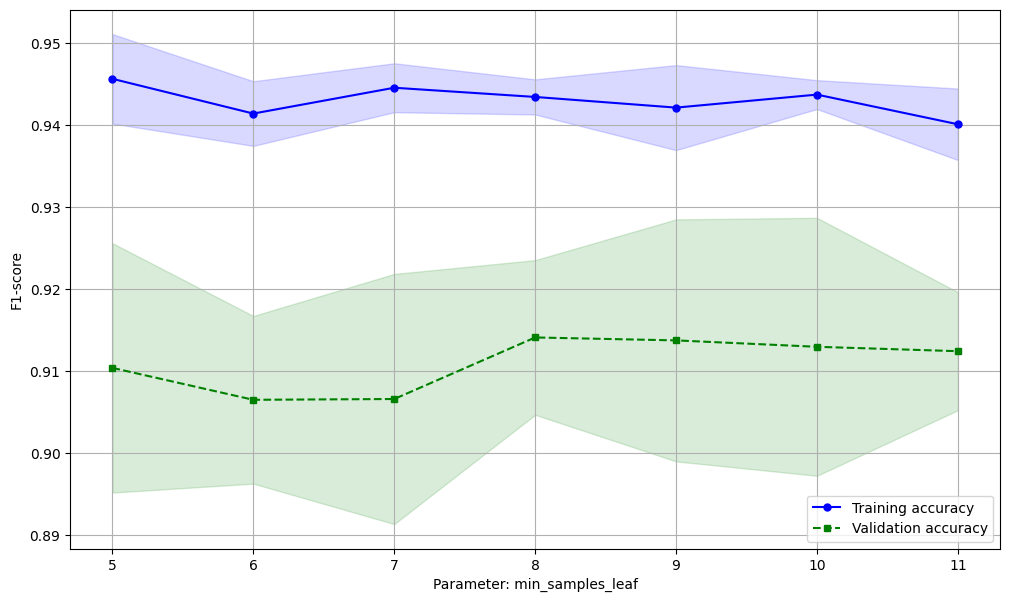

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_min_samples_leaf, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_min_samples_leaf,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_min_samples_leaf, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_min_samples_leaf,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter: min_samples_leaf')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')

min_samples_leaf will be fixed at 15

In [ ]:
best_model['classifier'].set_params(min_samples_leaf=15)

GradientBoostingClassifier(learning_rate=0.004, max_depth=4,
                           min_samples_leaf=15, min_samples_split=15,
                           n_estimators=420, subsample=0.65)

### Best model perfected

In [ ]:
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('noisy',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x3p_per_game',
                                                   'ft_per_game',
                                                   'orb_per_game',
                                                   'blk_per_game',
                                                   'pf_per_game', 'sos', 'pace',
                                                   'f_tr', 'x3p_ar',
                                                   'opp_ft_fga']),
                                                 ('clean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler...
                                                   'opp_tov_percent',
                                                   'opp_drb_percent'])])),
                ('sampler', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('dim_reduction',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LogisticRegression(),
                                           k_features=(7, 7), scoring='f1')),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.004, max_depth=4,
                                            min_samples_leaf=15,
                                            min_samples_split=15,
                                            n_estimators=420,
                                            subsample=0.65))])

## Prediction of playoffs teams in 2023

Now that we have finished perfecting our model, we can make the actual prediction of which NBA teams will make the playoffs in 2023

In [ ]:
current_ssn_X = current_ssn[['x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game','x2pa_per_game',
                             'x2p_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game',
                             'drb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game',
                             'pf_per_game', 'pts_per_game', 'age', 'pw', 'pl', 'mov', 'sos', 'srs', 'o_rtg',
                             'd_rtg', 'n_rtg', 'pace', 'f_tr', 'x3p_ar', 'ts_percent', 'e_fg_percent', 'tov_percent',
                             'orb_percent', 'ft_fga', 'opp_e_fg_percent', 'opp_tov_percent', 'opp_drb_percent', 'opp_ft_fga']]

In [ ]:
current_ssn_prediction = best_model.predict(current_ssn_X)

In [ ]:
current_ssn['playoffs'] = current_ssn_prediction

In [ ]:
playoffs_prediction = current_ssn[current_ssn['playoffs'] == 1]
playoffs_prediction

,season,team,playoffs,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,x2p_percent,ft_per_game,...,x3p_ar,ts_percent,e_fg_percent,tov_percent,orb_percent,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga
1,2023,Boston Celtics,True,16.0,42.6,0.377,26.2,46.2,0.567,NaN,...,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180
2,2023,Brooklyn Nets,True,12.8,33.8,0.378,28.7,51.3,0.559,17.7,...,0.397,0.598,0.562,12.7,19.6,0.208,0.530,12.2,73.7,0.212
3,2023,Chicago Bulls,True,10.4,28.9,0.361,32.1,57.9,0.555,17.6,...,0.333,0.587,0.550,12.2,20.1,0.203,0.544,13.5,77.8,0.197
5,2023,Cleveland Cavaliers,True,11.6,31.6,0.367,30.0,53.6,0.559,17.5,...,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,NaN
7,2023,Denver Nuggets,True,11.8,31.2,0.379,31.8,55.2,0.575,16.8,...,0.361,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201
9,2023,Golden State Warriors,True,16.6,43.2,0.385,26.5,47.0,0.564,16.0,...,0.479,0.600,0.571,14.1,24.4,0.178,0.540,12.3,76.0,0.214
12,2023,Los Angeles Clippers,True,12.7,33.4,0.381,28.4,52.7,0.539,18.7,...,0.387,0.588,0.551,12.8,22.9,0.217,0.543,11.7,76.6,0.195
13,2023,Los Angeles Lakers,True,10.8,31.2,0.346,32.1,57.8,0.555,20.6,...,NaN,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,NaN
14,2023,Memphis Grizzlies,True,12.0,34.2,0.351,31.7,57.9,0.548,17.5,...,0.372,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206
15,2023,Miami Heat,True,12.0,34.8,0.344,27.3,50.5,0.540,19.1,...,NaN,0.574,0.530,12.4,22.8,0.224,0.561,14.5,77.7,0.198


The model prediced that the teams that should have gone to the playoffs in 2023 were 19 instead of the actual 16, plus some teams that did make the playoffs didn't actually made the cut in this prediction (the Atlanta Hawks and the Minnesota Timberwolves, respectively 7th and 8th seed of their conferences).

It's worth mentioning that since a few years the NBA has inserted a new method in order to make the playoffs for lower-seed teams, according to which teams 10th to 6th for each conference have to compete in a sort of mini tournament, in which the top two teams would get the last two avaliable spots in the playoffs. This means that these last two spots aren't completely determined by team's performance in the regular season.

Overall the prediction isn't bad at all, since predicting the outcome of the leaderboards isn't as easy as it might seem.